# Modeling co-citation networks from historical records with R

Paolo Rossini, ORCID: 0000-0002-7582-3867 

__Abstract__: Co-citations can be very insightful when analyzed on a large scale. This tutorial, specifically devised for historians, offers a step-by-step guide for performing co-citation analysis with R. It is meant as a supplement to a research article currently under review. 

## Introduction

A co-citation occurs when two authors or publications are mentioned together in a third document. The more two authors or publications are co-cited, the more we can assume their views to be similar in the eyes of those who cite them. This information can be represented as a network where nodes representing authors or publications are linked together by edges representing co-citations. The resulting network will be composed of several "communities" or "clusters," which can be easily identified by means of a community detection algorithm such as the Louvain method. Roughly, each community will stand for a specific scientific area. Through a co-citation network, therefore, one can go beyond the study of *couples* of authors or publications and see how scientific *communities* relate to one another. 

In scientometrics, co-citation is one of the indicators for monitoring the development of the scientific field. In much the same way, we can use co-citation analysis to map the evolution of science in the past. Whereas in scientometrics co-citation analysis is usually applied to large corpora of scientific publications, we will use historical records as our data source. For the purpose of this tutorial, I have compiled a list of seventeenth-century letters mentioning ten scholars of my choice. The data was harvested from ePistolarium (http://ckcc.huygens.knaw.nl/epistolarium/).

The general workflow can be divided into three steps: data preparation (sec. 1), data normalization (sec. 2), data visualization (sec. 3). 

## 1. Data preparation

First, let us install and load the two required libraries.

In [1]:
# You will only need to install these once.  
# install.packages("igraph")
# install.packages("philentropy")

library("igraph")
library("philentropy")

Warning message:
“package ‘igraph’ was built under R version 4.1.2”

Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Warning message:
“package ‘philentropy’ was built under R version 4.1.2”


Then, let us have a look at our data set.  

In [2]:
scholars <- read.csv("data.csv", header = TRUE, sep = ";")
head(scholars)

,Letter.Id,Mentioned.Person
,<chr>,<chr>
1,huyg003/2165,"Descartes, René"
2,huyg003/1514,"Descartes, René"
3,huyg003/1516,"Descartes, René"
4,huyg003/1531,"Descartes, René"
5,huyg001/6554,"Huygens, Christiaan"
6,huyg003/1547,"Huygens, Christiaan"


In our data set, the scholars are connected to the letters in which they are mentioned. Yet our aim is to connect scholars with each other based on their co-citations. Technically, this amounts to projecting a two-mode network—in which there are two types of nodes (letters and scholars)—into a one-mode network—where nodes are only of one type (scholars). As a first step we need to transform our data set into an *incidence matrix*:

In [3]:
# creating graph from csv file
g <- graph.data.frame(scholars, directed = FALSE)

# identifying the two modes
V(g)$type <- bipartite_mapping(g)$typ

# converting the graph into an incidence matrix
incidence_matrix <- as_incidence_matrix(g)

head(incidence_matrix)

,"Descartes, René","Huygens, Christiaan","Wallis, John","Galilei, Galileo","Boyle, Robert","Hobbes, Thomas","Gassendi, Pierre","Leibniz, Gottfried Wilhelm","Newton, Isaac","Pascal, Blaise"
huyg003/2165,1,0,0,0,0,0,0,0,0,0
huyg003/1514,1,0,0,0,0,0,0,0,0,0
huyg003/1516,1,0,0,0,0,0,0,0,0,0
huyg003/1531,1,0,0,0,0,0,0,0,0,0
huyg001/6554,0,1,0,0,0,0,0,0,0,0
huyg003/1547,0,1,1,0,0,0,0,0,0,0


In our incidence matrix, rows represent letters (symbolized by their unique id) while columns represent scholars. Each row and each column share one cell that is marked with 1 if the corresponding letter mentions the corresponding scholar, or with 0 in case of no mention. 

To extract the co-citations from the incidence matrix, we convert it into an *adjacency matrix*. This can done by multiplying the incidence matrix A by its transpose, i.e., another matrix A<sup>T</sup> produced by switching the rows and columns of A. The result is a new matrix where both rows and columns represent scholars, and where cells represent the count of co-citations for each couple of scholars. 

Note that the diagonal of the adjacency matrix is set to 0 because we are only interested in co-citations and not individual citations.

In [4]:
# multiplying the incidence matrix by its transpose
adjacency_matrix <- t(incidence_matrix) %*% incidence_matrix

# setting the diagonal of the adjacency matrix to zero
diag(adjacency_matrix) <- 0 

head(adjacency_matrix) 

,"Descartes, René","Huygens, Christiaan","Wallis, John","Galilei, Galileo","Boyle, Robert","Hobbes, Thomas","Gassendi, Pierre","Leibniz, Gottfried Wilhelm","Newton, Isaac","Pascal, Blaise"
"Descartes, René",0,2,3,6,2,1,1,0,5,8
"Huygens, Christiaan",2,0,3,2,2,1,1,2,1,2
"Wallis, John",3,3,0,1,16,7,1,1,10,0
"Galilei, Galileo",6,2,1,0,0,0,2,0,1,2
"Boyle, Robert",2,2,16,0,0,5,1,2,9,2
"Hobbes, Thomas",1,1,7,0,5,0,1,0,1,0


## 2. Data normalization

The adjacency matrix presents us with the raw number of co-citations between scholars. Yet in scientometrics raw co-citation values are rarely taken as an index of similarity (Petrovich, 2020). There is a statistical reason for this.

Consider two scholars A and B, one being similar to the other. A, however, has many more individual citations than B, which in turn may translate into a larger number of co-citations between A and scholars other than B. In this perspective, B would become one of the many scholars A is connected with, thus weakening the similarity between A and B. 

This is why scholars of scientometrics prefer to normalize their data. In this way, they are able to mitigate the effects of anomalies such as those due to the presence of outliers in the data set. 

Normalizing here means replacing the raw co-citation values with a similarity score, a practice that allows for a more meaningful comparison between the different couples of scholars. 

There is no agreement in scientometrics on which similarity measure should be used to normalize the data (Eck and Waltman, 2009). A variety of measures have been proposed: cosine similarity, association strength, inclusion index, Jaccard index, Pearson’s correlation coefficient (r), and the chi-squared distance. 

We opt for cosine similarity—the most popular—thus obtaining a new matrix where each couple of scholars is assigned a similarity score from 0 to 1: 

In [5]:
# normalizing the data by using cosine similarity
similarity_matrix <-distance(t(incidence_matrix), method = "cosine", use.row.names = TRUE)

# setting the diagonal of the similarity matrix to zero
diag(similarity_matrix) <- 0

head(similarity_matrix)

Metric: 'cosine'; comparing: 10 vectors.



,"Descartes, René","Huygens, Christiaan","Wallis, John","Galilei, Galileo","Boyle, Robert","Hobbes, Thomas","Gassendi, Pierre","Leibniz, Gottfried Wilhelm","Newton, Isaac","Pascal, Blaise"
"Descartes, René",0.00000000,0.03014428,0.05442863,0.19674775,0.03057804,0.04490133,0.05184758,0.00000000,0.11053942,0.25400025
"Huygens, Christiaan",0.03014428,0.00000000,0.05086207,0.06128514,0.02857434,0.04195907,0.04845016,0.07911878,0.02065922,0.05933908
"Wallis, John",0.05442863,0.05086207,0.00000000,0.03688556,0.27516766,0.35355339,0.05832118,0.04761905,0.24868237,0.00000000
"Galilei, Galileo",0.19674775,0.06128514,0.03688556,0.00000000,0.00000000,0.00000000,0.21081851,0.00000000,0.04494666,0.12909944
"Boyle, Robert",0.03057804,0.02857434,0.27516766,0.00000000,0.00000000,0.21281413,0.04914732,0.08025724,0.18860838,0.06019293
"Hobbes, Thomas",0.04490133,0.04195907,0.35355339,0.00000000,0.21281413,0.00000000,0.14433757,0.00000000,0.06154575,0.00000000


## 3. Data visualization

For data visualization, we have two options. We can either download the similarity matrix by typing `write.csv(similarity_matrix,"similarity_matrix.csv")` and then import it on a network analysis application like Gephi (https://gephi.org/). Or we can stick to R and visualize the network using the `igraph` library as I will explain in this section. 

First, we create a graph from the similarity matrix. If the similarity score between two scholars is equal to 0, R will display the scholars in question as two unconnected nodes. If instead the similarity score is higher than 0, R will draw an edge between the two nodes.

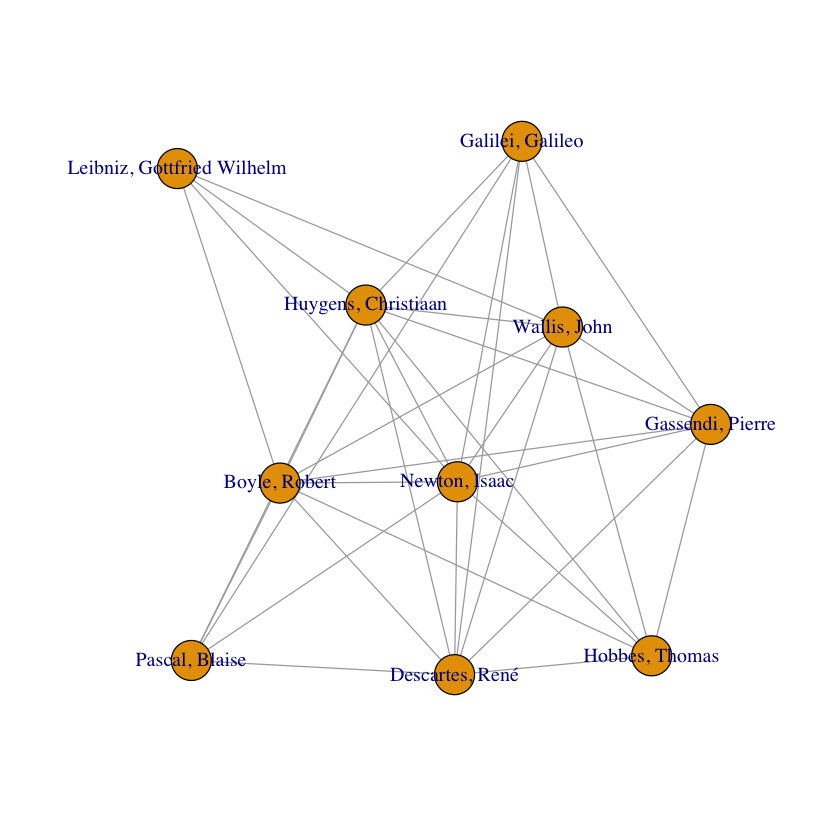

In [6]:
# creating the network from the similarity matrix
graph <- graph_from_adjacency_matrix(similarity_matrix, weighted = TRUE, mode = c("undirected"))

plot(graph, layout = layout_with_graphopt)

The similarity score also determines the edge weight: the higher the similarity score, the heavier the edge. Edge weight can take on different meanings depending on the network being analyzed; in our case, edge weight is a function of the strength of the similarity between scholars. Hence edge weight allows us to distinguish between weaker and stronger similarities and treat them accordingly.

Based on edge weight, we can measure two more values: weighted degree and modularity. 

Weighted degree corresponds to the number of edges a node has, pondered by the weight of each edge; for instance, the weighted degree of a node having two edges, each weighting two, will be four.

Modularity is a measure of the division of a network into modules (also called communities or clusters) which we can calculated by means of the Louvain community detection algorithm (Blondel et al., 2008).

Edge weight, weighted degree, and modularity all play a role in the way the final co-citation map looks like: the thickness of an edge is proportional to its weight; the size of a node is proportional to its weighted degree; the color of the nodes depends on the community they belong to.

Finally, we apply the `graphopt`layout to minimize overlaps between nodes and set a similar length for all edges. 

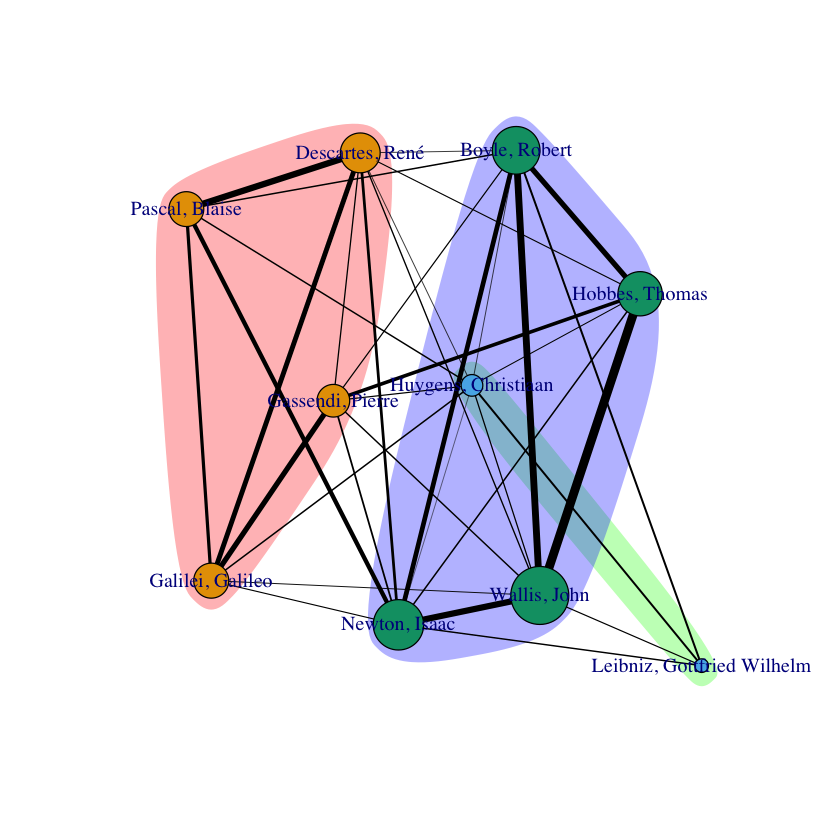

In [7]:
# measuring weighted degree
weighted_degree <- strength(graph)
V(graph)$size <- weighted_degree * 20

# measuring modularity using the Louvain method
modularity <- cluster_louvain(graph, weights = NULL, resolution = 1)

# matching edge width with edge weight
E(graph)$width <- E(graph)$weight * 20

plot(modularity, graph, layout = layout_with_graphopt, mark.border = "NA", edge.color = 'black')

The co-citation map is ready. Now it is time to interpret it based on what we know about the data at hand. This can be a tricky task given the complexity of historical data. Historiography can help us make sense of the co-citation maps by giving us an overview of the historical period being analyzed or by providing specific information about the historical actors involved. Even historiography, however, may fail to explain some of the trends or patterns emerging from the maps. This is where the close reading of the historical documents themselves becomes a necessity. By going back to the sources of our data, we can fill the gaps left open by historiography and perhaps stumble into evidence of relationships that historiography may have overlooked. This potential for fostering new research is, in my opinion, what makes co-citation analysis appealing to historians. 

## References

Blondel, V.D., Guillaume, J.-L., Lambiotte, R., Lefebvre, E., 2008. Fast unfolding of communities in large networks. J. Stat. Mech. 2008, P10008. https://doi.org/10.1088/1742-5468/2008/10/P10008.

Eck, N.J. van, Waltman, L., 2009. How to normalize cooccurrence data? An analysis of some well-known similarity measures. J. Am. Soc. Inf. Sci. 60, 1635–1651. https://doi.org/10.1002/asi.21075![image.png].

Petrovich, E., 2020. Science mapping [WWW Document]. URL https://www.isko.org/cyclo/science_mapping (accessed 4.27.22).